In [1]:
path='C:\\jupyter\\Explainable Healthcare framework\\Explainable_healthcareframework\\'


처리 중인 생성 모델: smote
경로 확인 c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework
y_train [0 1 2]
자동 계산된 클래스 가중치: [1.92034632 0.52057396 1.79113901]


c:\Users\jaemin\anaconda3\envs\jm_main\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.47205 | val_0_accuracy: 0.40851 |  0:00:07s
epoch 1  | loss: 0.98063 | val_0_accuracy: 0.58226 |  0:00:15s
epoch 2  | loss: 0.88675 | val_0_accuracy: 0.5516  |  0:00:23s
epoch 3  | loss: 0.82321 | val_0_accuracy: 0.61803 |  0:00:30s
epoch 4  | loss: 0.79083 | val_0_accuracy: 0.61325 |  0:00:38s
epoch 5  | loss: 0.74899 | val_0_accuracy: 0.57006 |  0:00:45s
epoch 6  | loss: 0.72495 | val_0_accuracy: 0.59232 |  0:00:53s
epoch 7  | loss: 0.70519 | val_0_accuracy: 0.58061 |  0:01:00s
epoch 8  | loss: 0.66658 | val_0_accuracy: 0.54484 |  0:01:08s
epoch 9  | loss: 0.6566  | val_0_accuracy: 0.46621 |  0:01:16s
epoch 10 | loss: 0.6326  | val_0_accuracy: 0.32608 |  0:01:23s
epoch 11 | loss: 0.61719 | val_0_accuracy: 0.30053 |  0:01:31s
epoch 12 | loss: 0.60257 | val_0_accuracy: 0.3762  |  0:01:39s
epoch 13 | loss: 0.59612 | val_0_accuracy: 0.30415 |  0:01:46s
epoch 14 | loss: 0.60664 | val_0_accuracy: 0.3152  |  0:01:54s
epoch 15 | loss: 0.57033 | val_0_accuracy: 0.34553 |  0

c:\Users\jaemin\anaconda3\envs\jm_main\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-14 18:19:11,598] A new study created in memory with name: no-name-aa32d923-64b0-4d90-86cc-11e656a35f34


원본 특성 shape: (48796, 6)
샘플별 마스크 평균 shape: (48796, 6)
원본 특성 shape: (6036, 6)
샘플별 마스크 평균 shape: (6036, 6)


c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\xgboost_optimizer.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\xgboost_optimizer.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\xgboost_optimizer.py:98: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will

tabnet_probs [[6.3846790e-05 9.9690163e-01 3.0345875e-03]
 [9.4843893e-09 9.9284536e-01 7.1545895e-03]
 [9.1324946e-05 4.7067102e-02 9.5284164e-01]
 ...
 [7.8743743e-04 4.1888878e-01 5.8032387e-01]
 [2.2677703e-16 6.2599313e-04 9.9937409e-01]
 [9.4791591e-07 1.5231359e-01 8.4768546e-01]]
xgb_probs [[0.15416563 0.7076757  0.13815871]
 [0.07428826 0.74928236 0.17642935]
 [0.10321527 0.6785995  0.21818525]
 ...
 [0.12558164 0.44920218 0.4252162 ]
 [0.1015223  0.49819928 0.40027845]
 [0.10992867 0.63400936 0.25606194]]

XGBoost Results:
Best Accuracy: 0.7114
Best Parameters:
  n_estimators: 296
  max_depth: 4
  learning_rate: 0.010223331275923231
  gamma: 0.003411804277459665
  min_child_weight: 4
  subsample: 0.8540011797249656
  colsample_bytree: 0.681855715337198
  reg_lambda: 0.0001985619207970993
  reg_alpha: 1.2906018177757703e-05


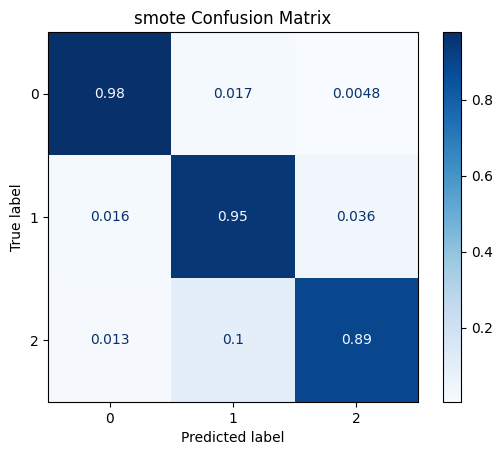


처리 중인 생성 모델: adasyn
경로 확인 c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework
y_train [0 1 2]
자동 계산된 클래스 가중치: [1.92787339 0.51983784 1.79334585]


c:\Users\jaemin\anaconda3\envs\jm_main\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.53057 | val_0_accuracy: 0.33597 |  0:00:07s
epoch 1  | loss: 0.99596 | val_0_accuracy: 0.59551 |  0:00:15s
epoch 2  | loss: 0.90991 | val_0_accuracy: 0.58758 |  0:00:22s
epoch 3  | loss: 0.88387 | val_0_accuracy: 0.56084 |  0:00:30s
epoch 4  | loss: 0.8375  | val_0_accuracy: 0.55539 |  0:00:37s
epoch 5  | loss: 0.81254 | val_0_accuracy: 0.59072 |  0:00:44s
epoch 6  | loss: 0.75783 | val_0_accuracy: 0.46954 |  0:00:52s
epoch 7  | loss: 0.7124  | val_0_accuracy: 0.42183 |  0:00:59s
epoch 8  | loss: 0.69033 | val_0_accuracy: 0.42645 |  0:01:07s
epoch 9  | loss: 0.64474 | val_0_accuracy: 0.34786 |  0:01:14s
epoch 10 | loss: 0.60128 | val_0_accuracy: 0.42348 |  0:01:22s
epoch 11 | loss: 0.57385 | val_0_accuracy: 0.36041 |  0:01:29s
epoch 12 | loss: 0.56365 | val_0_accuracy: 0.35826 |  0:01:36s
epoch 13 | loss: 0.57775 | val_0_accuracy: 0.31649 |  0:01:44s
epoch 14 | loss: 0.5553  | val_0_accuracy: 0.37576 |  0:01:51s
epoch 15 | loss: 0.55456 | val_0_accuracy: 0.34109 |  0

c:\Users\jaemin\anaconda3\envs\jm_main\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-14 18:56:21,145] A new study created in memory with name: no-name-497c2707-016c-4563-a473-88f864a99102


원본 특성 shape: (48727, 6)
샘플별 마스크 평균 shape: (48727, 6)
원본 특성 shape: (6022, 6)
샘플별 마스크 평균 shape: (6022, 6)


c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\xgboost_optimizer.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\xgboost_optimizer.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\xgboost_optimizer.py:98: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will

tabnet_probs [[5.88651710e-05 9.99818981e-01 1.22230573e-04]
 [1.01973291e-03 9.63279963e-01 3.57003324e-02]
 [4.92038438e-04 4.38487917e-01 5.61020076e-01]
 ...
 [1.26554591e-11 1.18223846e-01 8.81776154e-01]
 [6.68094469e-11 2.13189460e-02 9.78681028e-01]
 [6.07491835e-12 2.15331793e-01 7.84668148e-01]]
xgb_probs [[0.21771123 0.48972195 0.29256684]
 [0.19837084 0.51711863 0.28451052]
 [0.2805359  0.47648975 0.24297436]
 ...
 [0.13954005 0.5543619  0.30609807]
 [0.13954005 0.5543619  0.30609807]
 [0.14056781 0.5577053  0.3017269 ]]

XGBoost Results:
Best Accuracy: 0.6906
Best Parameters:
  n_estimators: 128
  max_depth: 4
  learning_rate: 0.025808246745864252
  gamma: 5.2769837975167916e-05
  min_child_weight: 6
  subsample: 0.9974308000355864
  colsample_bytree: 0.6233723626061444
  reg_lambda: 2.8104975203943614e-05
  reg_alpha: 4.1951492141935096e-07


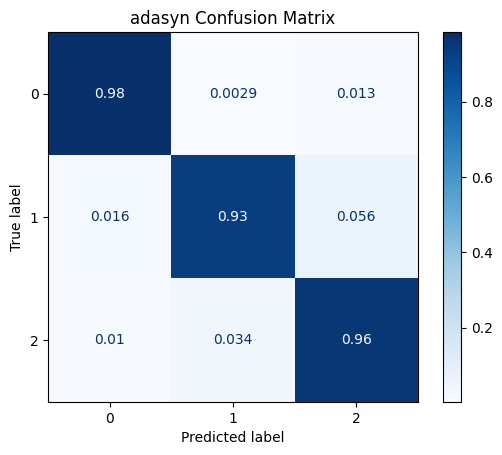


처리 중인 생성 모델: copulagan
경로 확인 c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework
y_train [0 1 2]
자동 계산된 클래스 가중치: [1.92034632 0.52057396 1.79113901]


c:\Users\jaemin\anaconda3\envs\jm_main\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.34777 | val_0_accuracy: 0.23327 |  0:00:07s
epoch 1  | loss: 0.78297 | val_0_accuracy: 0.25717 |  0:00:14s
epoch 2  | loss: 0.69498 | val_0_accuracy: 0.26756 |  0:00:22s
epoch 3  | loss: 0.66741 | val_0_accuracy: 0.26492 |  0:00:29s
epoch 4  | loss: 0.65088 | val_0_accuracy: 0.26624 |  0:00:36s
epoch 5  | loss: 0.635   | val_0_accuracy: 0.24118 |  0:00:44s
epoch 6  | loss: 0.62317 | val_0_accuracy: 0.22123 |  0:00:51s
epoch 7  | loss: 0.62001 | val_0_accuracy: 0.19651 |  0:00:59s
epoch 8  | loss: 0.61271 | val_0_accuracy: 0.19469 |  0:01:06s
epoch 9  | loss: 0.61193 | val_0_accuracy: 0.18892 |  0:01:13s
epoch 10 | loss: 0.60189 | val_0_accuracy: 0.2092  |  0:01:21s
epoch 11 | loss: 0.59644 | val_0_accuracy: 0.23442 |  0:01:28s
epoch 12 | loss: 0.5907  | val_0_accuracy: 0.24431 |  0:01:35s
epoch 13 | loss: 0.5822  | val_0_accuracy: 0.24184 |  0:01:43s
epoch 14 | loss: 0.58711 | val_0_accuracy: 0.29509 |  0:01:50s
epoch 15 | loss: 0.57788 | val_0_accuracy: 0.288   |  0

c:\Users\jaemin\anaconda3\envs\jm_main\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-14 19:19:44,941] A new study created in memory with name: no-name-d146439a-cf8d-4752-9523-f0bd8aef5e57


원본 특성 shape: (48796, 6)
샘플별 마스크 평균 shape: (48796, 6)
원본 특성 shape: (6036, 6)
샘플별 마스크 평균 shape: (6036, 6)


c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\xgboost_optimizer.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\xgboost_optimizer.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\xgboost_optimizer.py:98: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will

tabnet_probs [[0.00771542 0.95159394 0.04069058]
 [0.09306493 0.8293877  0.07754732]
 [0.0663273  0.68720984 0.24646282]
 ...
 [0.105537   0.6622391  0.23222393]
 [0.00617743 0.6510427  0.34277984]
 [0.13286164 0.02855839 0.8385801 ]]
xgb_probs [[0.09004083 0.77102536 0.13893376]
 [0.08494094 0.7886157  0.12644337]
 [0.08797307 0.7490521  0.16297486]
 ...
 [0.08563449 0.7885576  0.12580793]
 [0.13136227 0.7296345  0.13900317]
 [0.1219619  0.7006355  0.17740262]]

XGBoost Results:
Best Accuracy: 0.7734
Best Parameters:
  n_estimators: 125
  max_depth: 3
  learning_rate: 0.019521012953274925
  gamma: 1.2110644678289421e-06
  min_child_weight: 1
  subsample: 0.7301051383446799
  colsample_bytree: 0.993518225169718
  reg_lambda: 0.9425123364062722
  reg_alpha: 3.22159376021085e-06


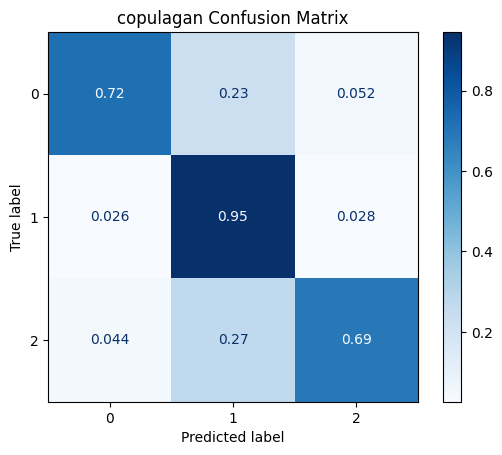


처리 중인 생성 모델: ctgan
경로 확인 c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework
y_train [0 1 2]
자동 계산된 클래스 가중치: [1.92284352 0.52057396 1.78897199]


c:\Users\jaemin\anaconda3\envs\jm_main\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.44759 | val_0_accuracy: 0.39565 |  0:00:07s
epoch 1  | loss: 0.89842 | val_0_accuracy: 0.45631 |  0:00:14s
epoch 2  | loss: 0.7965  | val_0_accuracy: 0.30218 |  0:00:22s
epoch 3  | loss: 0.74023 | val_0_accuracy: 0.2275  |  0:00:29s
epoch 4  | loss: 0.70325 | val_0_accuracy: 0.18134 |  0:00:36s
epoch 5  | loss: 0.6839  | val_0_accuracy: 0.18035 |  0:00:44s
epoch 6  | loss: 0.67981 | val_0_accuracy: 0.182   |  0:00:51s
epoch 7  | loss: 0.67675 | val_0_accuracy: 0.21794 |  0:00:58s
epoch 8  | loss: 0.66634 | val_0_accuracy: 0.20722 |  0:01:06s
epoch 9  | loss: 0.6563  | val_0_accuracy: 0.30185 |  0:01:13s
epoch 10 | loss: 0.63545 | val_0_accuracy: 0.25272 |  0:01:20s
epoch 11 | loss: 0.63403 | val_0_accuracy: 0.24893 |  0:01:28s
epoch 12 | loss: 0.61955 | val_0_accuracy: 0.27102 |  0:01:35s
epoch 13 | loss: 0.61889 | val_0_accuracy: 0.29707 |  0:01:42s
epoch 14 | loss: 0.61524 | val_0_accuracy: 0.36614 |  0:01:50s
epoch 15 | loss: 0.60024 | val_0_accuracy: 0.31701 |  0

c:\Users\jaemin\anaconda3\envs\jm_main\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-14 19:56:36,275] A new study created in memory with name: no-name-f8510dbb-0a51-4427-aa41-249673b08ca7


원본 특성 shape: (48796, 6)
샘플별 마스크 평균 shape: (48796, 6)
원본 특성 shape: (6036, 6)
샘플별 마스크 평균 shape: (6036, 6)


c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\xgboost_optimizer.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\xgboost_optimizer.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\xgboost_optimizer.py:98: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will

tabnet_probs [[7.2591280e-04 8.6238128e-01 1.3689277e-01]
 [1.8116510e-02 6.0302621e-01 3.7885734e-01]
 [1.5913664e-01 5.4501706e-01 2.9584631e-01]
 ...
 [9.9778134e-01 4.2289952e-07 2.2181789e-03]
 [3.4841627e-01 4.3924850e-01 2.1233518e-01]
 [9.8701608e-01 1.7690879e-06 1.2982213e-02]]
xgb_probs [[0.04454099 0.8274603  0.12799875]
 [0.07125714 0.83685994 0.09188295]
 [0.0692191  0.84255224 0.0882286 ]
 ...
 [0.8508572  0.10177701 0.04736576]
 [0.12369303 0.7775886  0.09871836]
 [0.63821006 0.1117744  0.25001556]]

XGBoost Results:
Best Accuracy: 0.7821
Best Parameters:
  n_estimators: 115
  max_depth: 4
  learning_rate: 0.03521912379249876
  gamma: 5.581087292775024e-07
  min_child_weight: 1
  subsample: 0.9991686680570643
  colsample_bytree: 0.6694332300471474
  reg_lambda: 0.044376873258215856
  reg_alpha: 0.00766970843779617


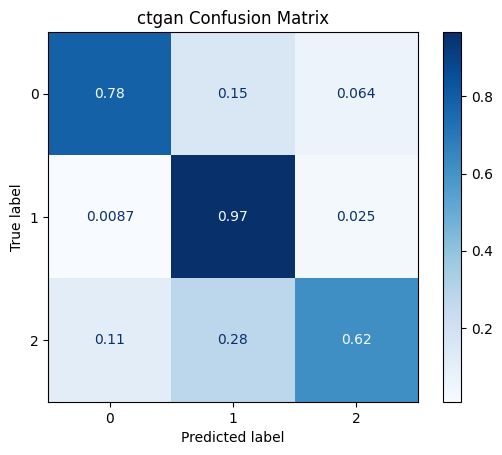


처리 중인 생성 모델: nbsynthetic
경로 확인 c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework
y_train [0 1 2]
자동 계산된 클래스 가중치: [1.92284352 0.52057396 1.78897199]


c:\Users\jaemin\anaconda3\envs\jm_main\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.24927 | val_0_accuracy: 0.31767 |  0:00:07s
epoch 1  | loss: 0.49048 | val_0_accuracy: 0.18381 |  0:00:14s
epoch 2  | loss: 0.3931  | val_0_accuracy: 0.15216 |  0:00:22s
epoch 3  | loss: 0.34094 | val_0_accuracy: 0.17656 |  0:00:29s
epoch 4  | loss: 0.29493 | val_0_accuracy: 0.16485 |  0:00:37s
epoch 5  | loss: 0.27119 | val_0_accuracy: 0.18002 |  0:00:44s
epoch 6  | loss: 0.26192 | val_0_accuracy: 0.22239 |  0:00:51s
epoch 7  | loss: 0.24202 | val_0_accuracy: 0.29558 |  0:00:59s
epoch 8  | loss: 0.23304 | val_0_accuracy: 0.38592 |  0:01:06s
epoch 9  | loss: 0.22164 | val_0_accuracy: 0.4512  |  0:01:14s
epoch 10 | loss: 0.21258 | val_0_accuracy: 0.4761  |  0:01:21s
epoch 11 | loss: 0.21533 | val_0_accuracy: 0.46851 |  0:01:28s
epoch 12 | loss: 0.21345 | val_0_accuracy: 0.5821  |  0:01:36s
epoch 13 | loss: 0.21194 | val_0_accuracy: 0.64754 |  0:01:43s
epoch 14 | loss: 0.21239 | val_0_accuracy: 0.66897 |  0:01:51s
epoch 15 | loss: 0.19997 | val_0_accuracy: 0.72849 |  0

c:\Users\jaemin\anaconda3\envs\jm_main\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-14 20:14:28,218] A new study created in memory with name: no-name-efc12d7e-93e8-4514-9e52-b34370231edb


원본 특성 shape: (48796, 6)
샘플별 마스크 평균 shape: (48796, 6)
원본 특성 shape: (6036, 6)
샘플별 마스크 평균 shape: (6036, 6)


c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\xgboost_optimizer.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\xgboost_optimizer.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\xgboost_optimizer.py:98: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will

tabnet_probs [[1.2723508e-01 8.5466421e-01 1.8100657e-02]
 [9.3733676e-02 8.9170957e-01 1.4556725e-02]
 [2.8595515e-03 8.4002262e-01 1.5711784e-01]
 ...
 [9.9999475e-01 4.0309205e-06 1.1489764e-06]
 [9.9999952e-01 5.1222449e-10 4.2534882e-07]
 [9.9840945e-01 3.2476510e-05 1.5581293e-03]]
xgb_probs [[0.06375378 0.86682135 0.06942488]
 [0.05763018 0.8768831  0.0654868 ]
 [0.12923777 0.7883888  0.08237342]
 ...
 [0.7542129  0.11245555 0.1333315 ]
 [0.38562015 0.46495673 0.14942315]
 [0.52294254 0.25894287 0.21811458]]

XGBoost Results:
Best Accuracy: 0.8940
Best Parameters:
  n_estimators: 82
  max_depth: 5
  learning_rate: 0.028632966092879568
  gamma: 1.8912091113148022e-06
  min_child_weight: 1
  subsample: 0.8340676595614626
  colsample_bytree: 0.7949593566134447
  reg_lambda: 8.42079359284477
  reg_alpha: 0.004440989293188971


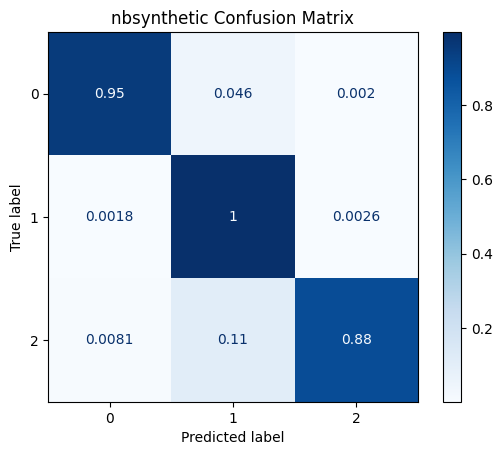


결과 요약:
                  Model  Accuracy  F1score  Precision   Recall
0        smote-proposed   0.94185  0.94202    0.94257  0.94185
1       adasyn-proposed   0.94271  0.94389    0.94852  0.94271
2    copulagan-proposed   0.86050  0.85663    0.85790  0.86050
3        ctgan-proposed   0.87144  0.86581    0.86721  0.87144
4  nbsynthetic-proposed   0.96769  0.96724    0.96839  0.96769
결과가 model_metrics.csv에 저장되었습니다.


In [6]:
# main.py
import pandas as pd
import torch
import numpy as np
# 로컬 모듈 임포트
from data_preparation import preprocess_data, convert_to_tensor
from encoding_tabnet import train_tabnet_classifier, create_augmented_features2,create_augmented_features
from xgboost_optimizer import optimize_and_compare_models
from utils import standardize_features, calculate_metrics, save_model, print_results
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 프로젝트 루트 디렉토리 경로 (현재 파일의 상위 디렉토리)
Generation_list = ['smote','adasyn','copulagan','ctgan','nbsynthetic']

"""메인 함수"""
# 빈 리스트 생성하여 결과 저장
model_results_list = []

# Generation_list는 외부에서 정의되어야 함
Generation_list = ['smote','adasyn','copulagan','ctgan','nbsynthetic']

for generation in Generation_list:
    print(f"\n처리 중인 생성 모델: {generation}")
    
    # 1. 데이터 전처리
    X_train, y_train, X_valid, y_valid, X_test, y_test = preprocess_data(generation)
    
    print("y_train",np.unique(y_train))
    # 2. TabNet 모델 학습
    tabnet_model = train_tabnet_classifier(X_train, y_train, X_valid, y_valid)

    # 3. 모델 저장
    model_save_path = path+f'\\3_1.Training_XAI_Proposed\\model_hist\\{generation}_proposed_tabnetEmbedd2.pickle'
    save_model(tabnet_model, model_save_path)
    tabnet_probs = tabnet_model.predict_proba(X_test)
    
    # 4. TabNet 확률 예측
    
    # 5. TabNet 임베딩 추출
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_features = create_augmented_features(tabnet_model, X_train)
    test_features = create_augmented_features(tabnet_model, X_test)

    
    # 6. XGBoost 모델 최적화 및 학습
    results, xgb_pred, best_xgb, xgb_probs = optimize_and_compare_models(
        train_features, 
        test_features, 
        y_train.astype(int), 
        y_test.astype(int), 
        n_trials=10,
        return_proba=True  # 확률값 반환하도록 수정
    )
    
    # 7. TabNet과 XGBoost 확률 합산   
    print("tabnet_probs",tabnet_probs)
    print("xgb_probs",xgb_probs)

    # 확률 합산
    
    combined_probs = (tabnet_probs + xgb_probs)
    
    # # 가장 높은 확률을 가진 클래스 선택
    ensemble_pred = np.argmax(combined_probs, axis=1)
    # 8. 결과 출력
    print_results(results)
    
    # 9. XGBoost 모델 저장
    xgb_save_path = path+f'\\3_1.Training_XAI_Proposed\\model_hist\\{generation}_proposed.pickle'
    save_model(best_xgb, xgb_save_path)
    
    # 10. 성능 지표 계산 (앙상블 예측 사용)
    accuracy, f1, precision, recall = calculate_metrics(y_test, ensemble_pred)
    
    # 11. 결과를 딕셔너리로 저장
    result_dict = {
        'Model': f"{generation}-proposed",
        'Accuracy': round(accuracy, 5),
        'F1score': round(f1, 5),
        'Precision': round(precision, 5),
        'Recall': round(recall, 5)
    }
    
    # Confusion matrix 계산
    cm = confusion_matrix(y_test, ensemble_pred, normalize='true')
    # Confusion matrix 시각화
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{generation} Confusion Matrix")
    plt.show()
    # 12. 리스트에 딕셔너리 추가
    model_results_list.append(result_dict)

# 13. 데이터프레임 생성
df_proposed = pd.DataFrame(model_results_list)
print("\n결과 요약:")
print(df_proposed)

# 14. 데이터프레임을 CSV 파일로 저장
output_path = 'model_metrics.csv'
df_proposed.to_csv(output_path)
print(f"결과가 {output_path}에 저장되었습니다.")


    

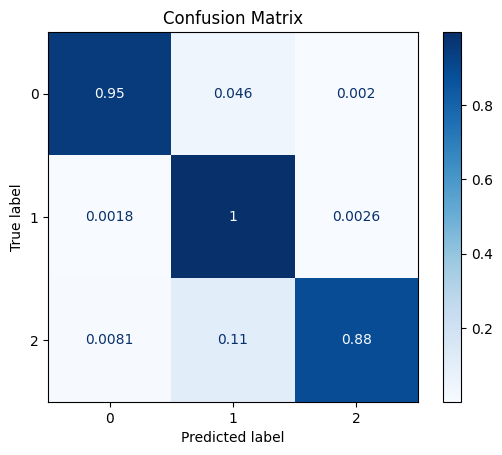

In [9]:

# Confusion matrix 계산
cm = confusion_matrix(y_test, ensemble_pred, normalize='true')

# Confusion matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
# 12. 리스트에 딕셔너리 추가
model_results_list.append(result_dict)